# RDF Data and Machine Learning

Here we try to extract a graph from a triple store generated with RDFLib as a computational graph. The main graph focuses on a bipartite graph with two semantics of skills and jobCategorys. The main task here is to recommend new skills for a jobCategory title. However, due to the usual demand for data cleaning, we would also like to present an example use of LLMs and graph structure analysis to recommend clustering of skills, which can be used as a new semantic for grouping. In the following notbook we will focus on:

1. Extracting Graph from Triple Store
2. SimRank Similarity Concept
3. Semantic Assitance with LLMs and Graph Eigen Calculation

## Solve Dependencies

The notebook is set either running it on Google Colab or locally on your machine. 

- Runing on Google Colab, will pull the repository and set environment in the colab. 
- Running locally on your computer, consider you have already pulled the repo, will set the environment, but environment activation will not set the ipykernel and you need to do it manually.

This note books use to source codes from `./src/`, as following:

- `rdf_to_nx.py` this code contains the queries to build the computational graph.
- `graph_tools.py` that includes computations on the computational graph, networkx. Main focus is on SimRank evaluations to match it to Job-Skill proposed method. Additionally, there is the package that support visualizing the graph with Semantic coloring. For adding more semantics you can add it to `PlotLib`.

To be able to use openAI embedding you need to set your API key in `/.env`, e.g.

```python
OPENAI_API_KEY='sk-..'
```

In [1]:
import os

# Constants vairiables
SETUP = 'colab' #'local'
REPO_NAME = 'dataweek_brox_24_internal'
COLAB_PATH = '/content'
ENV_DIR = 'env-dw24'
GRAPH_DB_ENDPOINT = {
    'endpoint': "https://sd-84c02130.stardog.cloud:5820/user3/query",
    'user': 'user3', 
    'password': 'red#green#bird'
}


if SETUP == 'colab':
  %cd {COLAB_PATH}
  if not os.path.isdir(REPO_NAME):

    !git clone https://github.com/brox-it/dataweek_brox_24_internal.git
    %cd {REPO_NAME}/
  else:
    %cd {REPO_NAME}/
    !git pull

else:
  %cd ..

if not os.path.isdir(ENV_DIR):
  !pip3 install virtualenv
  !virtualenv {ENV_DIR}
  !source {ENV_DIR}/bin/activate
  !pip install -r requirements.txt
else:
  !source {ENV_DIR}/bin/activate
%cd notebooks

/Users/anahitapakiman/Repos/brox/dataweek_brox_24_internal
/Users/anahitapakiman/Repos/brox/dataweek_brox_24_internal/notebooks


In [2]:
import _path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import csv
import pickle
from langchain.embeddings import OpenAIEmbeddings
from pyvis.network import Network
from dotenv import load_dotenv
from sklearn.cluster import KMeans

from rdf_to_nx import GraphLib
from graph_tools import PlotLib, SimRankLib

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

## 1. Extracting Graph from Triple Store

<div style="text-align:center;">
        <img src="../images/rdf_to_nx.png" width="800">
        <img src="../images/computation_graph_0.png" width="800">
</div>

In [3]:
GL_0 = GraphLib(GRAPH_DB_ENDPOINT)
G0 = GL_0.jobCategory_skill(20, nJob=10, nSkill=5)
print(G0)

Graph with 34 nodes and 26 edges


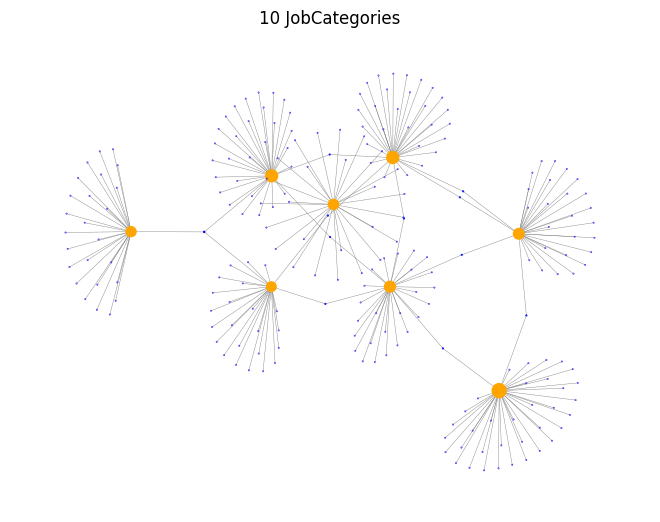

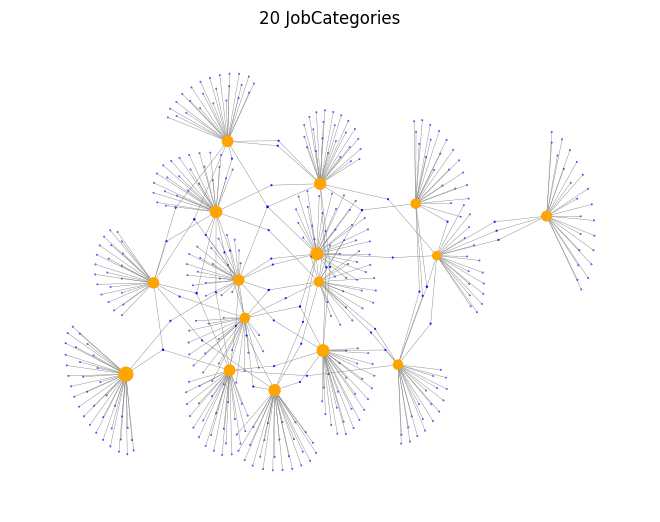

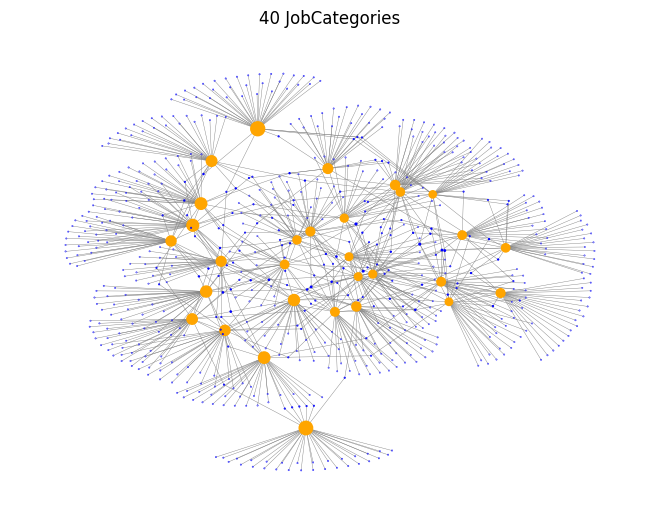

In [4]:
for n in [10, 20, 40]:#, 80, 160, 320]:

    GL_0 = GraphLib(GRAPH_DB_ENDPOINT)
    GL_0.jobCategory_skill(50, nJob=n, nSkill=50)
    GL_0.pl.plot_graph_plt(clean=False)#, label=True) 
    plt.title(f'{n} JobCategories' ) 
    plt.show()

## 2. . SimRank Similarity Concept

Definition: two objects are considered to be similar if they are referenced by similar objects


<img src="../images/simrank.png" width="600">
<img src="../images/link_pred.png" width="600">

Cleaning nodes with degree more than 10


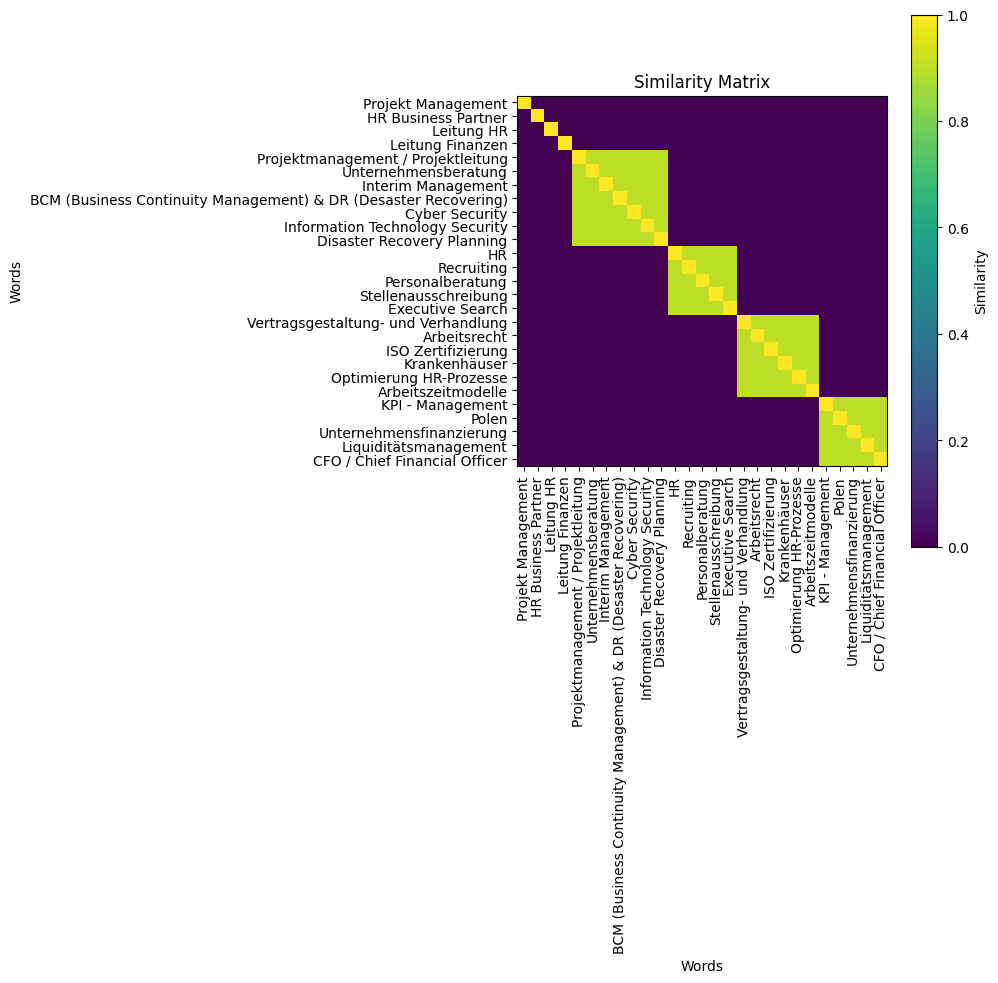

In [5]:
NJ = 5
NC = 10
D_LMT= 10

GL = GraphLib(GRAPH_DB_ENDPOINT)
GL.jobCategory_skill(D_LMT, nJob=NJ, nSkill=NC) 

GL.fn.graph_simrank()

plt.figure(figsize=(10, 10))
GL.pl.plot_heatmap(GL.fn.sr_np)
plt.show()

### 2.1. High Ranked Skill Pairs

<img src="../images/skills.png" width="400">

In [6]:
def find_most_similar_nodes(similarity_scores):
    most_similar = {}
    for node, scores in similarity_scores.items():
        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        most_similar[node] = sorted_scores[1][0]  # Excluding the node itself
    return most_similar

In [7]:
NJ = 20
NC = 20
D_LMT= NC

GL = GraphLib(GRAPH_DB_ENDPOINT)
GL.jobCategory_skill(D_LMT, nJob=NJ, nSkill=NC) 

GL.fn.graph_simrank()


sim_pair = find_most_similar_nodes(GL.fn.sr)
for s1, s2 in sim_pair.items():
    if GL.G.nodes()[s1]['semantic'] == 'Skill':
        name1 = GL.G.nodes()[s1]['name']
        name2 = GL.G.nodes()[s2]['name']
        print(f'| {name1} | {name2} |')


Cleaning nodes with degree more than 20
| Projektmanagement / Projektleitung | Unternehmensberatung |
| Unternehmensberatung | Projektmanagement / Projektleitung |
| Interim Management | Projektmanagement / Projektleitung |
| BCM (Business Continuity Management) & DR (Desaster Recovering) | Projektmanagement / Projektleitung |
| Cyber Security | Projektmanagement / Projektleitung |
| Information Technology Security | Projektmanagement / Projektleitung |
| Desaster Recovery Planung | Projektmanagement / Projektleitung |
| Business Recovery | Projektmanagement / Projektleitung |
| Recovery after Cyber Attack | Projektmanagement / Projektleitung |
| Polen | Projektmanagement / Projektleitung |
| Belgium | Projektmanagement / Projektleitung |
| Projektsteuerung | Projektmanagement / Projektleitung |
| Datenschutz-Grundverordnung | Key Account Management |
| HR | Stellenausschreibung |
| Recruiting | HR |
| Personalberatung | HR |
| Stellenausschreibung | HR |
| Executive Search | HR |
| So

### 2.2 Similarity Distribution

- Node degree limit=20

Cleaning nodes with degree more than 20


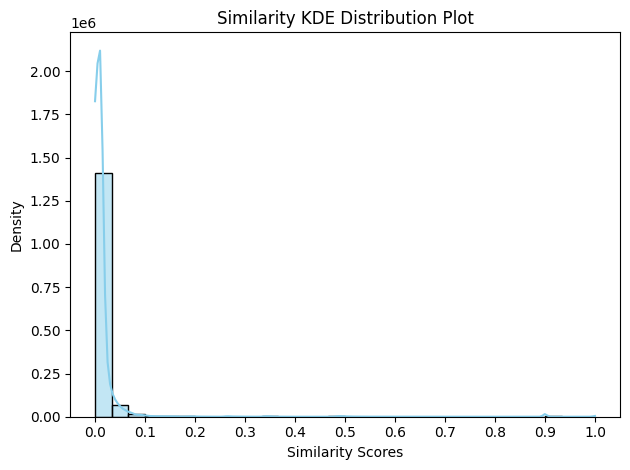

In [8]:
NJ = 200
NC = 20
D_LMT= NC

GL = GraphLib(GRAPH_DB_ENDPOINT)
GL.jobCategory_skill(D_LMT, nJob=NJ, nSkill=NC) 
GL.fn.graph_simrank()

GL.pl.plot_KDE(GL.fn.sr_np)

plt.show()

- Node degree limit=40

Cleaning nodes with degree more than 40
Graph with 59 nodes and 58 edges


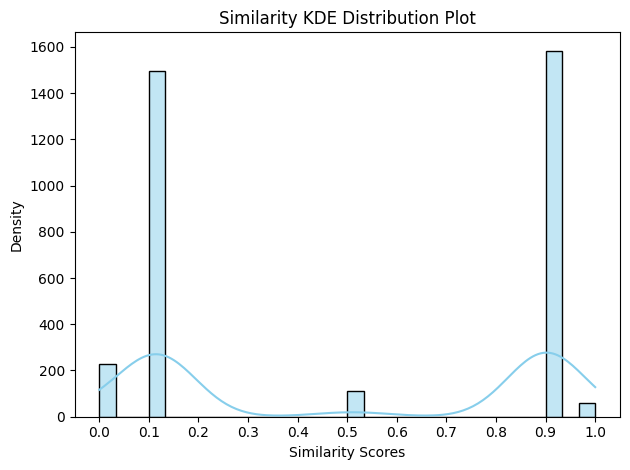

In [9]:
NJ = 40
NC = 10000
D_LMT= 40

GL = GraphLib(GRAPH_DB_ENDPOINT)
GL.jobCategory_skill(D_LMT, nJob=NJ, nSkill=NC) 
GL.fn.graph_simrank()
print(GL.G)

GL.pl.plot_KDE(GL.fn.sr_np)

plt.show()

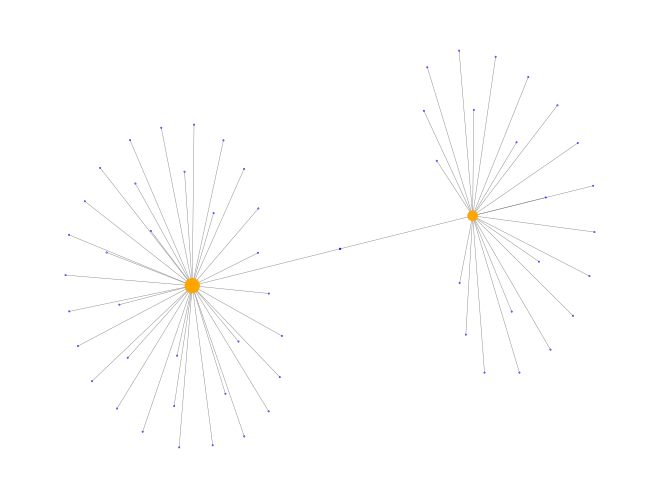

In [10]:
GL.pl.plot_graph_plt()
plt.show()

Graph with 59 nodes and 792 edges


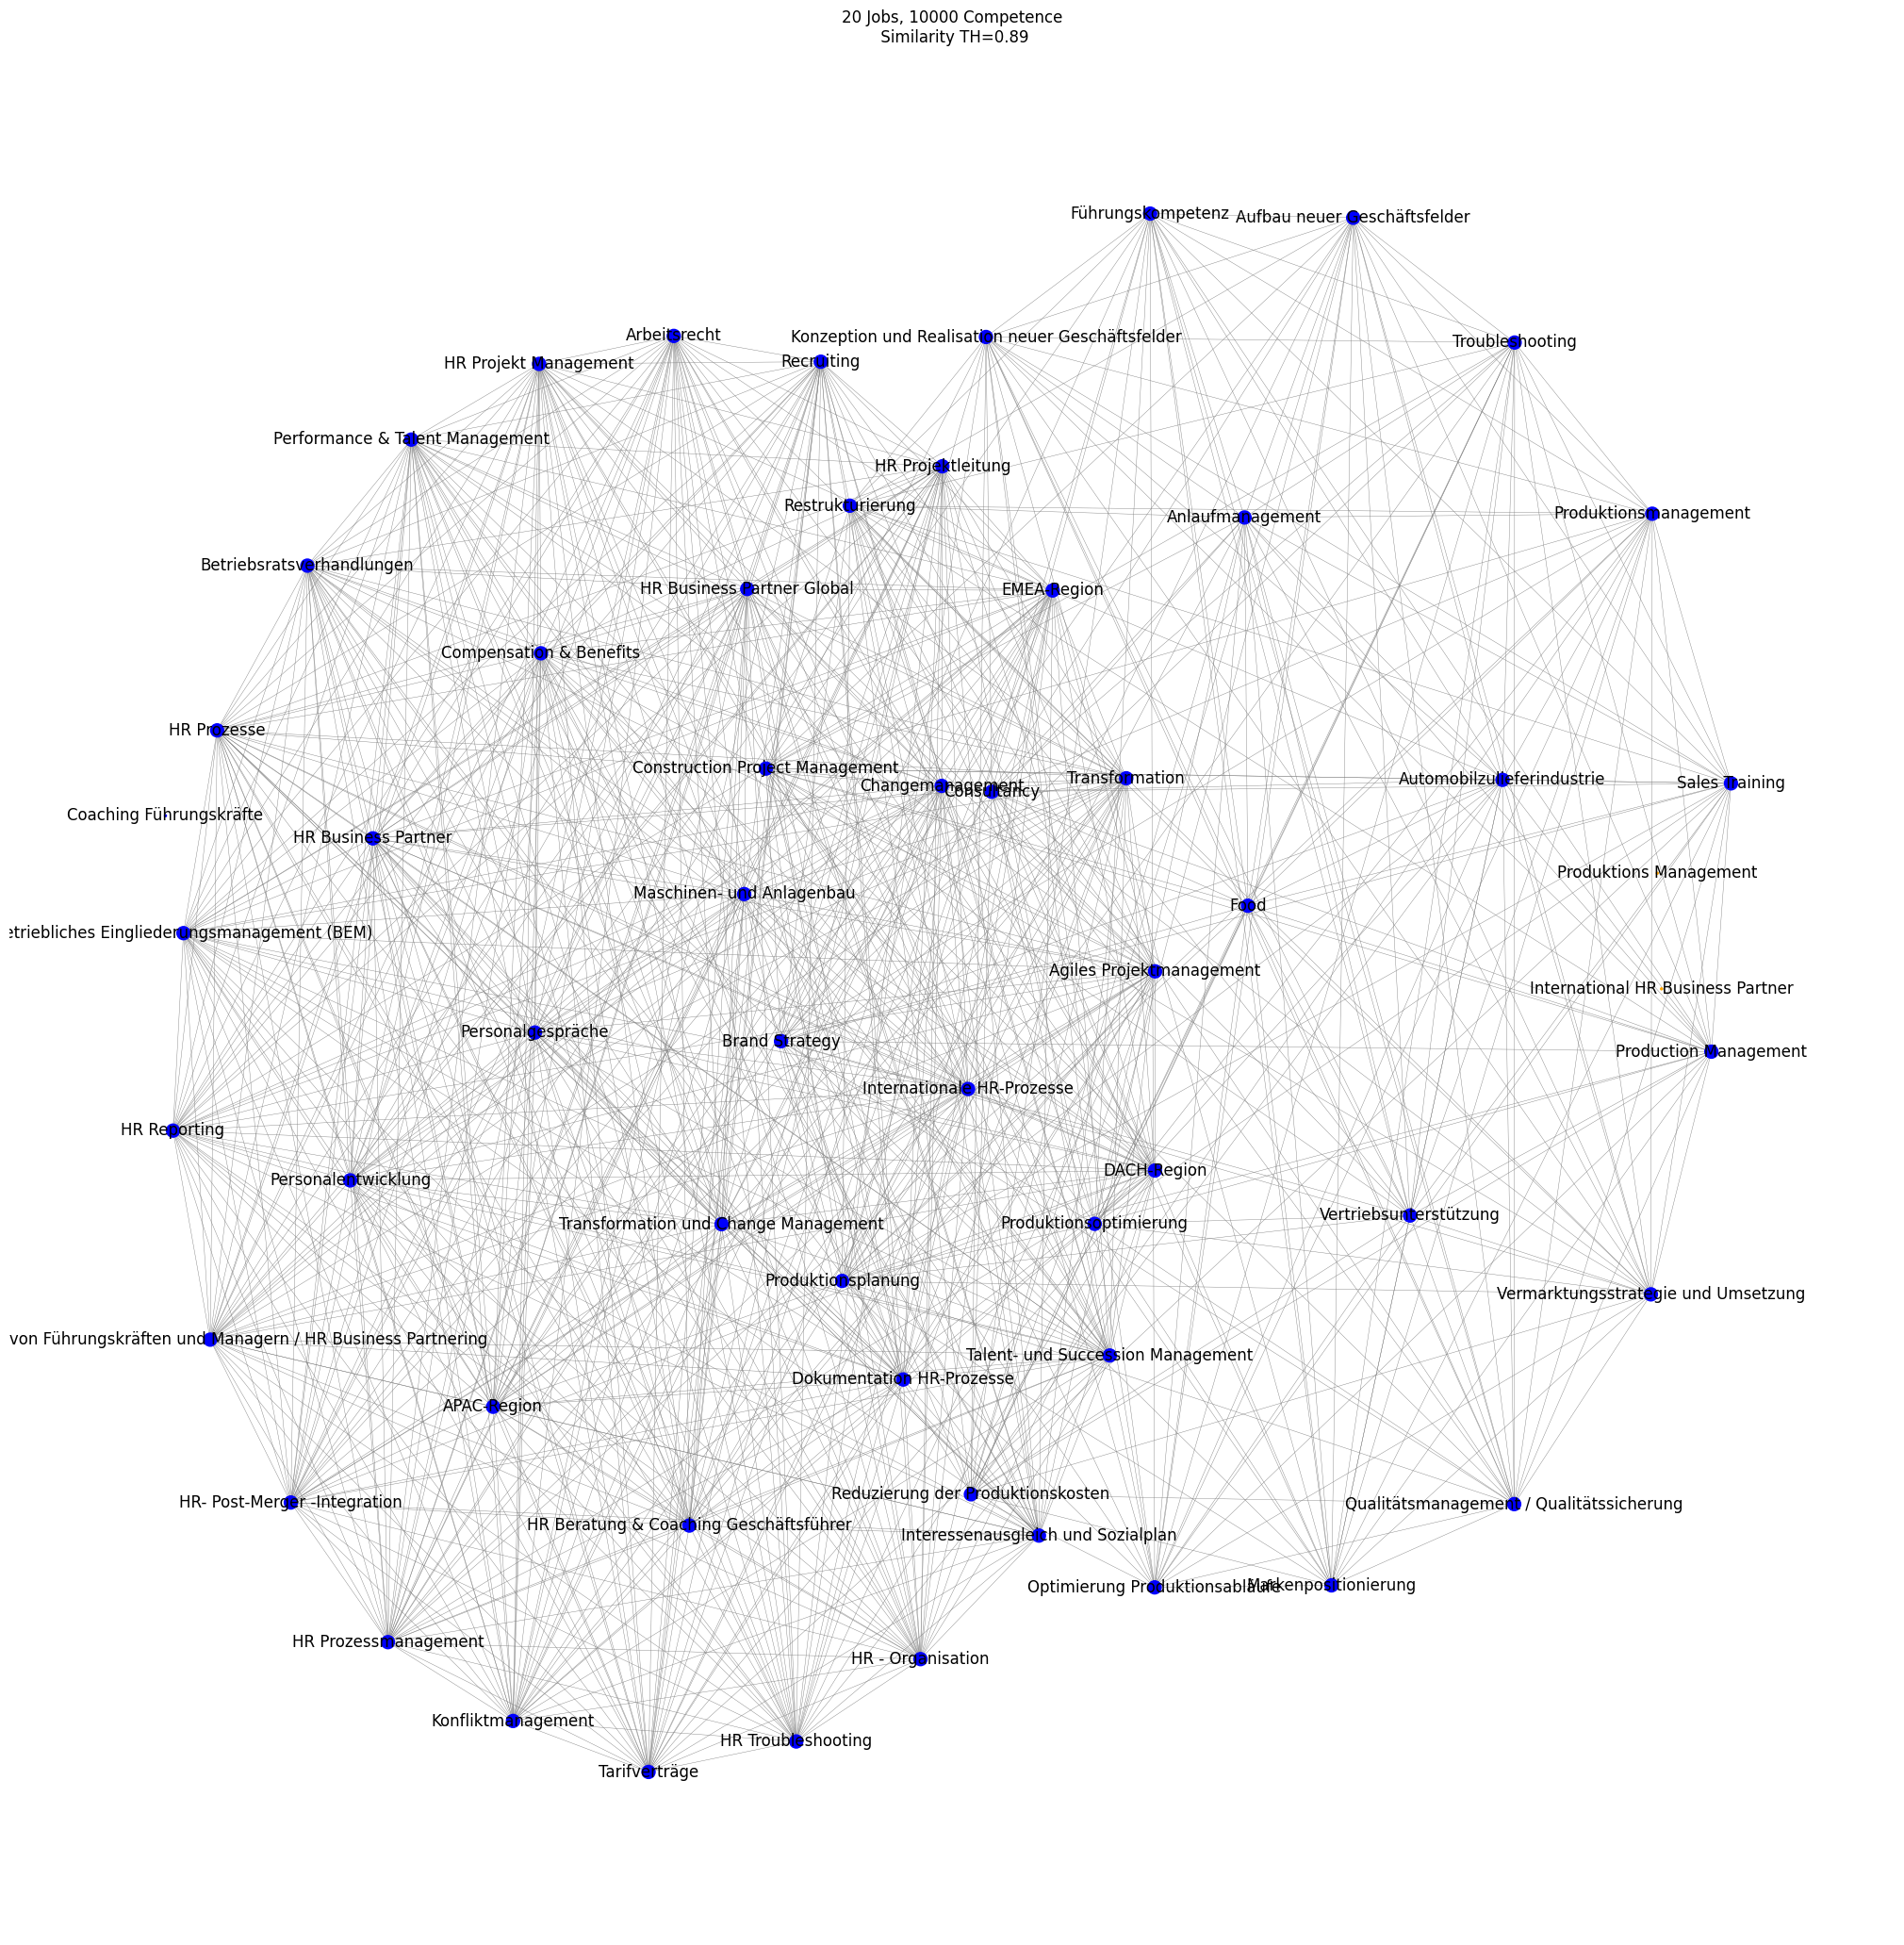

In [11]:
SIM_LMT = .89
NJ = 20
NC = 10000
D_LMT= 10

sr = GL.fn.sr

# Add edges to the graph, weighted by the similarity scores
G1 = nx.Graph()
G1.add_nodes_from(GL.G.nodes(data=True))

for i in sr:
    for j, value in sr[i].items():
        if i != j:
            if value > SIM_LMT:
                G1.add_edge(i, j, weight=value)
print(G1)

PL = PlotLib(G1, D_LMT)
plt.figure(figsize=(20, 20))
PL.plot_graph_plt(label=True)
plt.title(f'{NJ} Jobs, {NC} Competence\n Similarity TH={SIM_LMT}' ) 
plt.show()

### 2.3. Skills Recommendation Based on Job Similarities

<img src="../images/jobs.png" width="400">

In [12]:
NJ = 500
NC = 10000
D_LMT= 50

JC_GRAPH_PATH = f'data/jobCategory_{NJ}_cometences_{NC}_Dlmt_{D_LMT}.gml'
JC_SIMRANK_GRAPH_PATH = f'data/jobCategory_{NJ}_cometences_{NC}_Dlmt_{D_LMT}_simrank.npy'

if os.path.isfile(JC_GRAPH_PATH):
    G2 = nx.read_gml(JC_GRAPH_PATH)
    sr_np = np.load(JC_SIMRANK_GRAPH_PATH, allow_pickle=True)


else:
    GL = GraphLib(GRAPH_DB_ENDPOINT)
    GL.jobCategory_skill(D_LMT, nJob=NJ, nSkill=NC) 

    GL.fn.graph_simrank()

    G2 = GL.G
    sr_np = GL.fn.sr_np
    nx.write_gml(G2, JC_GRAPH_PATH, stringizer=str)
    np.save(JC_SIMRANK_GRAPH_PATH , sr_np)


print(G2)


# Find the isolated nodes
isolated_nodes = []
for node in G2.nodes():
    if G2.degree(node) == 0:
        isolated_nodes.append(node)

# Print the isolated nodes
print(isolated_nodes)

Graph with 1780 nodes and 2791 edges
[]


In [13]:
def get_node_index(G, id):
    nodes_list = list(G.nodes())
    node_index = nodes_list.index(id)

    return node_index

Graph with 78 nodes and 103 edges


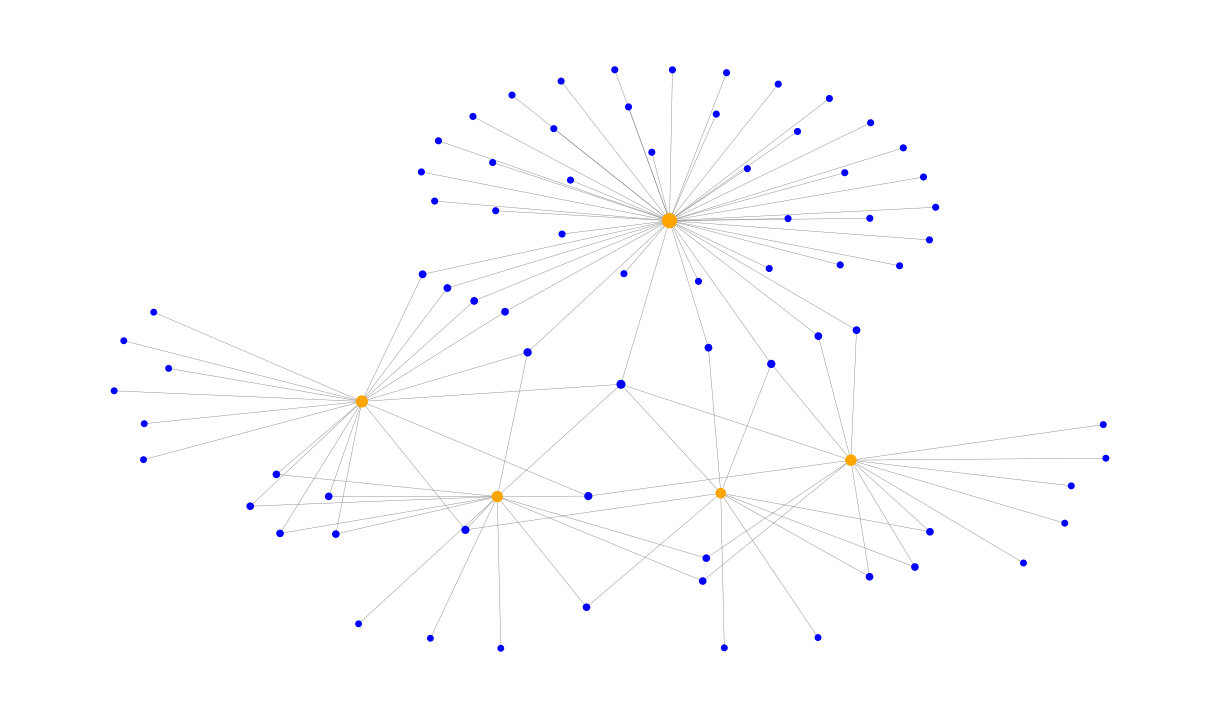

In [23]:
JOB = 'https://data.brox.de/dwt24/JobCategory_466' # Senior Recruiting Beratun

n_jobCategory_TH = 5
n_skill_TH = 5


gf_G = SimRankLib(G2, sr_np, JOB, n_jobCategory_TH, n_skill_TH, 'JobCategory', 'Skill')
sG = gf_G.subgraph_highrank_cnctd_nodeA()
print(sG)

# Visualize the subgraph (optional)
plt.figure(figsize=(12, 7))
PL = PlotLib(sG, None)
PL.plot_graph_plt(sG, label=False , pr_scale=0.5)
plt.show()

In [20]:
# Evaluate the ranking for job skills

gf_G.rank_setB_for_nodeA()
# # print(gf_G.sLib_sG.sr_np)


 Job Title:  Senior Recruiting Beratung
-----------------------------------------------------------------------------------------------


('Senior Recruiting Beratung',
            Recommendation Semantic  Similarity  Degree
 72        Active Sourcing    Skill    0.456380     5.0
 68       Interviewführung    Skill    0.555781     3.0
 69     Personalvorauswahl    Skill    0.555135     3.0
 70  End-to-End Recruiting    Skill    0.554099     3.0
 71             Recruiting    Skill    0.535847     3.0
 ..                    ...      ...         ...     ...
 45      Personalgespräche    Skill    0.900000     1.0
 46        Personalführung    Skill    0.900000     1.0
 47     Automobilindustrie    Skill    0.900000     1.0
 48              Interview    Skill    0.900000     1.0
 49        Active Sourcing    Skill    0.900000     1.0
 
 [73 rows x 4 columns])

## 3. Semantic Assitance with LLMs and Graph Eigen Calculation

### 3.1 Embedding Graph

<img src="../images/embedding.png" width="100%">

In [ ]:
NJ = 1
NC = 20000
D_LMT= NC
SIM_LMT = .899

CSV_FILE = 'data/comp.csv'

if not os.path.isfile(CSV_FILE):

    GL = GraphLib(GRAPH_DB_ENDPOINT)
    G3 = GL.job_skill(D_LMT, nJob=NJ, nSkill=NC) 
    
    skills = [[d['name']] for _, d in G3.nodes(data=True) if d['semantic'] == 'Skill']

    with open(CSV_FILE, 'w') as file:
        writer = csv.writer(file)
        writer.writerows(skills)


comp_df = pd.read_csv(CSV_FILE, names=['Skills'])
comp_df

Skills
0                   Projektmanagement / Projektleitung
1                                 Unternehmensberatung
2                                   Interim Management
3    BCM (Business Continuity Management) & DR (Des...
4                                       Cyber Security
..                                                 ...
685                                            England
686                                        Consultancy
687                                 Process Management
688                                           Coaching
689                    Construction Project Management

[690 rows x 1 columns]

In [ ]:
EMBD_FILE = 'result/comp_embd.pkl'

if not os.path.isfile(EMBD_FILE):
    embeddings_model = OpenAIEmbeddings(openai_api_key=openai_api_key)
    embeddings = embeddings_model.embed_documents(comp_df['Skills'].to_list())

    with open(EMBD_FILE, 'wb') as f:
        pickle.dump(embeddings, f)

with open(EMBD_FILE, 'rb') as f:
    embeddings = pickle.load(f)
    embeddings = np.array(embeddings)


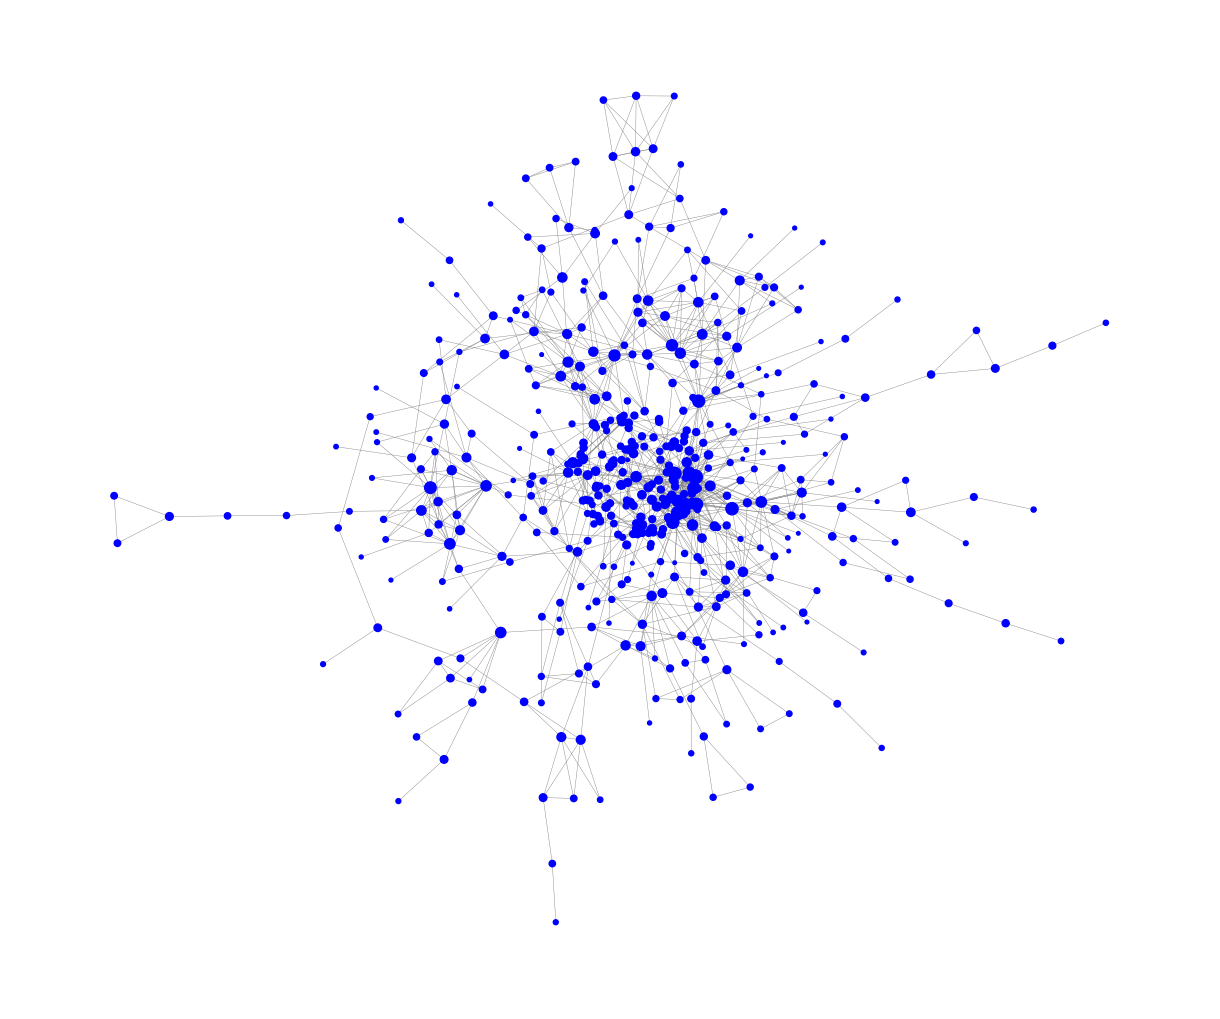

In [ ]:
similarity_threshold = 0.89

# Similarity
embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
cosine_similarity_matrix = np.dot(embeddings_norm, embeddings_norm.T)
adj_matrix = (cosine_similarity_matrix >= similarity_threshold).astype(int)

G4 = nx.Graph()
num_nodes = adj_matrix.shape[0]
edge_list = []
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if adj_matrix[i, j] == 1:
            edge_list.append((i, j))


for row in comp_df.iterrows():
    name = row[1].to_list()[0]
    G4.add_node(row[0], name=name, semantic='Skill')

G4.add_edges_from(edge_list)

# Visualize the subgraph (optional)
plt.figure(figsize=(12, 10))
PL = PlotLib(G4, None)
PL.plot_graph_plt(label=False , pr_scale=1, FA2=False, clean=True)
plt.show()

### 3.2. Graph Eigenvecotre Assistance for Grouping

In [ ]:
def choose_n_split(G):

    A = nx.to_numpy_array(G)
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    L

    # eigenvalues and eigenvectors
    vals, vecs = np.linalg.eigh(L)

    # sort these based on the eigenvalues
    vecs = vecs[:,np.argsort(vals)]
    vals = vals[np.argsort(vals)]

    nr, nc = 1, 5
    fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize=(15, 2))
    k = 0
    # for i in range(nr):
    for j in range(nc):
        sort_vals = np.sort(vecs[:, k])
        axes[j].plot(sort_vals, marker='o')
        axes[j].set_title(f'eigen vector {k}')
        k+=1

    plt.show()

    return vecs

In [ ]:
def cluster_graph(G, i=2):
    vecs = choose_n_split(G)
    inputs = input('eigen and number of clusters: a, b').split(',')
    try:
        i, n_clusters = [int(x) for x in inputs]
    except ValueError:
        print('Process Terminated')
        return
    
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(vecs[:,i].reshape(-1, 1))

    return(clusters)

In [ ]:
def split_graph(G, clusters):
    subgraphs = {}

    for node, cluster in zip(G.nodes, clusters):
        if cluster not in subgraphs:
            subgraphs[cluster] = nx.Graph()
        subgraphs[cluster].add_node(node)
        subgraphs[cluster].add_edges_from(G.edges(node))

    colors =  ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'lime', 'pink', 'brown', 'gray']

    pos = nx.spring_layout(G)  # You can use other layout algorithms
    plt.figure(figsize=(5, 3))
    for i, (cluster, subgraph) in enumerate(subgraphs.items()):
        nx.draw(subgraph, pos, node_color=colors[i % len(colors)], label=f'Cluster {cluster}', node_size=10, edge_color='gray')
# 
    plt.legend()
    plt.show()
    return(subgraphs)

In [ ]:
def plot_clusters(G, clusters):
    for node, cluster in zip(G.nodes, clusters):
        G.nodes[node]['cluster'] = cluster
    
    plt.figure(figsize=(12, 10))
    PL = PlotLib(G, None)
    node_colors = [G.nodes[node]['cluster'] for node in G.nodes]
    PL.plot_graph_plt(label=True , pr_scale=1, FA2=False, clean=False, node_colors=node_colors)
    plt.show()

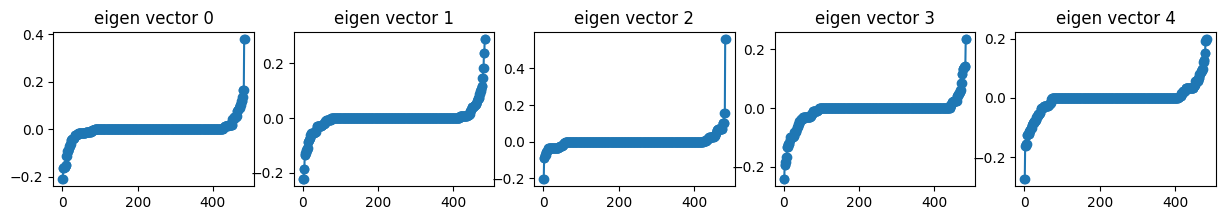

Process Terminated


In [ ]:
def make_subgraphs(G):
    clusters = cluster_graph(G)
    if clusters is not None:
        sG = split_graph(G, clusters)
        return(sG)
    return



def rm_multi(ids, my_list):
    ids.sort(reverse=True)

    for index in ids:
        my_list.pop(index)
    return(my_list)

def sort_resp(check, graphs, graphs_store, sG=None): 
    if not sG:
        sG = make_subgraphs(graphs[0])
        if not sG:
            return
    decis = input('Subgraph to continue processing:')
    if decis == 'No':
        check = []
    else:
        try:
            graphs_store = rm_multi(check, graphs)
            check = decis.split(',')
            check = [int(ci) for ci in check]
        except ValueError:
            print('Process Terminated')
            return
        graphs = [sG[i] for i in check]
        sG = rm_multi(check, sG)
        graphs_store.append(sG)

        for gi in graphs:    
            sG = make_subgraphs(gi)
            if sG:
                resp = sort_resp(check, graphs, graphs_store, sG=sG)
                if resp: check, graphs, sG = resp
                else:
                    return
            else:
                return
        
    return(check, graphs, sG, graphs_store)


check = [0]
graphs = [G4]
graphs_store = [G4]
sort_resp(check, graphs, graphs_store)